<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/PANDA_EF_Net_%26_More.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminary Setup

In [2]:
#!pip install tensorflow==2.1.0
!pip install tensorflow-addons==0.9.1
!pip install -q efficientnet --upgrade

     |████████████████████████████████| 1.0MB 2.8MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [0]:
import re, os, gc
import sys, time
import math
import pprint
gc.enable()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (train_test_split, 
                                     KFold, 
                                     StratifiedKFold)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
import efficientnet.tfkeras as efn

In [4]:
from google.colab import files; files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhtsingh","key":"dcd184742d2df1ff3dbfb96833c0c0f1"}'}

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle 
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d rhtsingh/panda-331x331-resized-images
files.upload()

 96% 472M/494M [00:03<00:00, 199MB/s]
100% 494M/494M [00:03<00:00, 161MB/s]


Saving sample_submission.csv to sample_submission.csv
Saving train.csv to train.csv
Saving test.csv to test.csv


{'sample_submission.csv': b'image_id,isup_grade\n005700be7e06878e6605e7a5a39de1b2,0\n005c6e8877caf724c600fdce5d417d40,0\n0104f76634ff89bfff1ef0804a95c380,0\n',
 'test.csv': b'image_id,data_provider\n005700be7e06878e6605e7a5a39de1b2,radboud\n005c6e8877caf724c600fdce5d417d40,karolinska\n0104f76634ff89bfff1ef0804a95c380,radboud\n',
 'train.csv': b'image_id,data_provider,isup_grade,gleason_score\n0005f7aaab2800f6170c399693a96917,karolinska,0,0+0\n000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0\n0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4\n001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4\n001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0\n002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0\n003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3\n0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3\n003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3\n003d4dd6bd61221ebc0bfb9350db333f,karolinska,1,3+3\n00412139e6b04d1e1cee8421f38f6e90,karolinska,0,0+0\n004391d48d58b18156f811087cd38abf,karolinska,1,

In [7]:
!ls -GFlash --color

total 495M
4.0K drwxr-xr-x 1 root 4.0K Apr 27 20:46 ./
4.0K drwxr-xr-x 1 root 4.0K Apr 27 20:42 ../
4.0K drwxr-xr-x 1 root 4.0K Apr 23 16:11 .config/
495M -rw-r--r-- 1 root 494M Apr 27 20:45 panda-331x331-resized-images.zip
4.0K drwxr-xr-x 1 root 4.0K Apr  3 16:24 sample_data/
4.0K -rw-r--r-- 1 root  125 Apr 27 20:45 sample_submission.csv
4.0K -rw-r--r-- 1 root  149 Apr 27 20:46 test.csv
512K -rw-r--r-- 1 root 509K Apr 27 20:46 train.csv


In [8]:
!unzip panda-331x331-resized-images.zip
!rm -r panda-331x331-resized-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_label_masks/train_label_masks/88ef695f58a55195f0730b4090583f4c_mask.png  
  inflating: train_label_masks/train_label_masks/88fb00fabc97d341a95e97a593c3fc43_mask.png  
  inflating: train_label_masks/train_label_masks/88fcb6de1ead418b238f198a635179c0_mask.png  
  inflating: train_label_masks/train_label_masks/88fd1b3540f148486d5987f4ba55b02f_mask.png  
  inflating: train_label_masks/train_label_masks/8900095e28a92eebb25f469b67d29b84_mask.png  
  inflating: train_label_masks/train_label_masks/890b1b3fc51fa2caf03d7bef25a31336_mask.png  
  inflating: train_label_masks/train_label_masks/890d0c582d769f001e95fa6f38252daf_mask.png  
  inflating: train_label_masks/train_label_masks/89159e7316ccc0d364591c421a5c7e56_mask.png  
  inflating: train_label_masks/train_label_masks/891f54c0f474191384a4b5e2d97b4696_mask.png  
  inflating: train_label_masks/train_label_masks/89272db689ac176dbad0d77bc23df032_mask.png  
  inflating: train_

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## Versioning

In [2]:
# Check API version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

TensorFlow version: 2.2.0-rc3
Keras version: 2.3.0-tf


## Check for Hardware Accelarator

In [3]:
print(f"TensorFlow is executing eagerly: {tf.executing_eagerly()}")
print("No of physical devices available: {}".format(len(tf.config.experimental.list_physical_devices())))
if not len(tf.config.experimental.list_physical_devices()) == 0:
    print("GPU is available." if tf.test.is_gpu_available() else "TPU is available.")

TensorFlow is executing eagerly: True
No of physical devices available: 4
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available.


### Minor Code Adjustments

In [4]:
print(f"Initializing radom seeds ..")
tf.random.set_seed(2020)

print(f"Enabling TensorFlow Device Debugger ..")
tf.config.set_soft_device_placement(False)
tf.debugging.set_log_device_placement(False)

%reload_ext tensorboard

print("Done.")

Initializing radom seeds ..
Enabling TensorFlow Device Debugger ..
Done.


## Check TPU

In [5]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.compat.v1.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


### Enable TPU

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif len(gpus) >= 1: # multiple GPUs in one VM
    strategy = tf.distribute.MirroredStrategy(gpus)
else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
REPLICAS:  1


In [7]:
strategy

### Enable XLA Compiler

In [0]:
tf.config.optimizer.set_jit(True)

## Model Config

In [0]:
AUTO = tf.data.experimental.AUTOTUNE

RESOLUTION = [331, 331]
NUM_CHANNELS = 3

EPOCHS = 20
FOLDS = 5
SEED = 2020
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE
FIRST_FOLD_ONLY = False

data_root = "train_images/"

tf_record_dir = os.path.join(data_root, "tfrecord_data")
tf_record_array_dir = os.path.join(data_root, "tfrecord_array_data")

In [0]:
def get_paths_and_labels():
    return [(os.path.join("train_images/train_images/", i), int(train[train.image_id==i.split(".")[0]].isup_grade.values)) for i in os.listdir("train_images/train_images/")]

In [0]:
def write_to_tfrecords(decoded_resolution=None):
  if decoded_resolution:
    record_dir = os.path.join(tf_record_array_dir, str(decoded_resolution))
  else:
    record_dir = tf_record_dir

  if os.path.exists(record_dir):
    return
  os.makedirs(record_dir, exist_ok=True)

  print("Converting images to TFRecords...")
  records_per_shard = 50

  shard_number = 0
  path_template = os.path.join(record_dir, "shard_{0:04d}.tfrecords")
  writer = tf.io.TFRecordWriter(path_template.format(shard_number))
  for i, (image_path, label) in enumerate(get_paths_and_labels()):
    if i and not (i % records_per_shard):
      shard_number += 1
      writer.close()
      writer = tf.io.TFRecordWriter(path_template.format(shard_number))

    with open(image_path, "rb") as f:
      image_bytes = f.read()

    if decoded_resolution:
      # TODO(robieta): make this faster with imap
      image = tf.io.decode_jpeg(image_bytes)
      image = tf.cast(image, tf.float32)
      image = tf.image.resize(image, (decoded_resolution,) * 2)
      if image.shape[2] == 1:
        image = tf.tile(image, (1, 1, 3))
      image_bytes = tf.io.encode_jpeg(
        tf.cast(image, tf.uint8)
      ).numpy()


    record_bytes = tf.train.Example(features=tf.train.Features(feature={
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes])),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    })).SerializeToString()

    writer.write(record_bytes)

  writer.close()
  print("TFRecord conversion complete.")


RECORD_PATTERN = os.path.join(tf_record_dir, "*.tfrecords")
RESIZED_RECORD_PATTERN = os.path.join(tf_record_array_dir, "{}", "*.tfrecords")
RECORD_SCHEMA = {
    "image": tf.io.FixedLenFeature([], dtype=tf.string),
    "label": tf.io.FixedLenFeature([1], dtype=tf.int64)
}

#write_to_tfrecords()

assert RESOLUTION[0] == RESOLUTION[1], "Resize is hard coded to square images."
write_to_tfrecords(RESOLUTION[0])

In [0]:
TRAINING_FILENAMES = tf.io.gfile.glob("train_images/tfrecord_array_data/*/*.tfrecords") 

In [0]:
def decode_image(image_data):
    image = tf.image.decode_png(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*RESOLUTION, 3])
    return image

def transform_image(image, label):
  image = tf.image.random_flip_left_right(image)
  if bool(np.random.uniform(size=(1,))>0.7):
    image = tf.image.random_flip_up_down(image)
  return image, label

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64), 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return image, label

def load_dataset(filenames, labeled = True, ordered = False):    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    return dataset 

In [0]:
def get_training_dataset(dataset, do_aug=False):
    dataset = dataset.map(transform_image, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.batch(AUG_BATCH)
    # if do_aug: 
    #     dataset = dataset.unbatch().map(apply_rotation, num_parallel_calls=AUTO).batch(AUG_BATCH).map(transform, num_parallel_calls=AUTO)
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    # if do_onehot: dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [0]:
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES, labeled=True, ordered=True),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH)

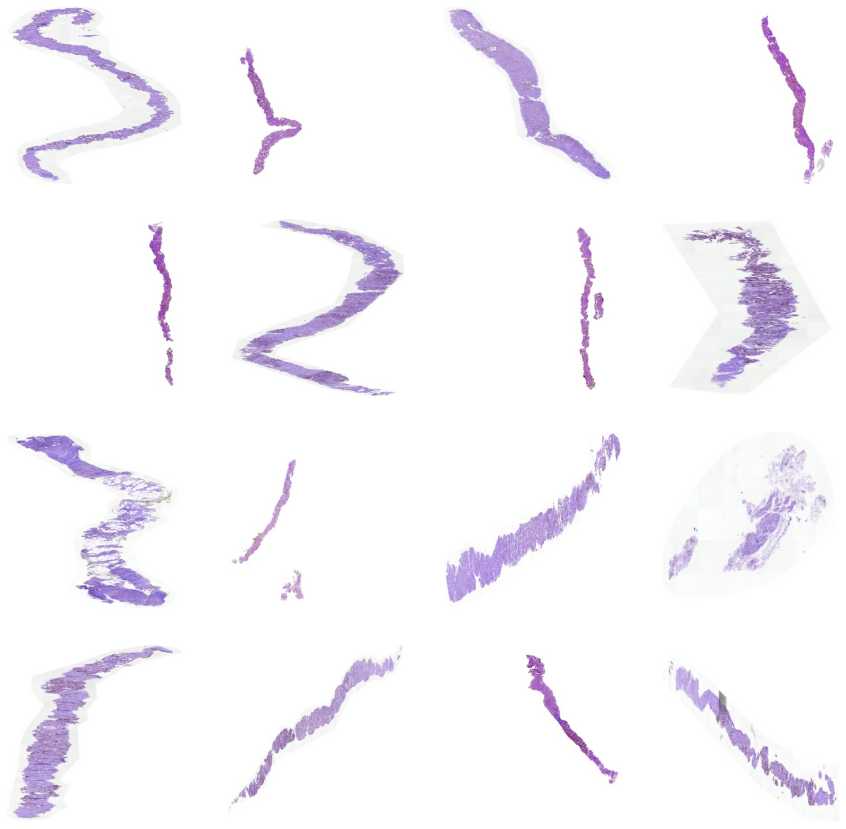

In [16]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [0]:
y_train = train.isup_grade.values
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(zip(np.unique(y_train),class_weights))

In [0]:
def get_model(model_name):
    with strategy.scope():
        if model_name == 'efn-b7':
            efnet = efn.EfficientNetB7(input_shape=[*RESOLUTION, 3],
                                       weights='noisy-student',
                                       include_top=False)
        elif model_name == 'efn-b6':
            efnet = efn.EfficientNetB6(input_shape=[*RESOLUTION,3],
                                       weights='noisy-student',
                                       include_top=False)
        elif model_name == 'efn-b5':
            efnet = efn.EfficientNetB5(input_shape=[*RESOLUTION,3],
                                       weights='noisy-student',
                                       include_top=False)
        efnet.trainable = True
        model = tf.keras.Sequential([
            efnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(5),
            tf.keras.layers.Activation("softmax", dtype='float32', name='predictions')
        ])
        model.compile(
            optimizer='adam',
            loss = "sparse_categorical_crossentropy",
            metrics=['sparse_categorical_accuracy',tfa.metrics.CohenKappa(num_classes=5,weightage='quadratic')]
        )
    return model

1e-05 1.2738188573441265e-05


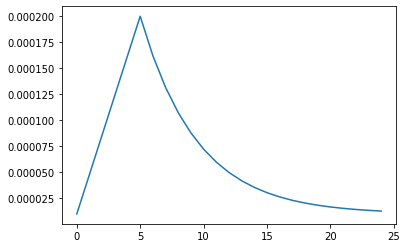

In [23]:
if strategy.num_replicas_in_sync == 8:
    start_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    min_lr = 0.00001
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1:
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: 
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8
    
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
    
import os
def get_callbacks(model_name):
    if not os.path.exists(str(model_name)+"_callback_output"):
        os.mkdir(str(model_name)+"_callback_output")

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
    #tqdm_callback = tfa.callbacks.TQDMProgressBar()
    checkpoint = tf.keras.callbacks.ModelCheckpoint(str(model_name)+"_callback_output" + '/best.h5', 
                              monitor = 'val_loss', 
                              verbose = True, save_best_only=True, 
                              mode = 'min',
                              save_weights_only = True)
    csv_logger = tf.keras.callbacks.CSVLogger(str(model_name)+"_callback_output" + '/log.csv')
    early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2,verbose=True)
    return [lr_callback, checkpoint, early, csv_logger]

rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [0]:
def train_cross_validate(folds, model_name):
    histories = []
    models = []
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
    
        print(); print('#'*30); print('### FOLD',f+1); print('#'*30)
        
        train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[trn_ind]['TRAINING_FILENAMES']), labeled = True)
        val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES']), labeled = True, ordered = True)
        
        with strategy.scope():
            model = get_model(model_name)
            callbacks = get_callbacks(model_name)
        
        history = model.fit(
            get_training_dataset(train_dataset, do_aug=False), 
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = EPOCHS,
            callbacks = callbacks,
            validation_data = get_validation_dataset(val_dataset),
            class_weight=class_weights,
            verbose=True
        )
        
        models.append(model)
        histories.append(history)
        
        tf.compat.v1.reset_default_graph()
        del model
        gc.collect()
        
        if FIRST_FOLD_ONLY: break
        
    return histories, models

In [0]:
def train_and_predict(folds, model_name):
    
    # test_ds = get_test_dataset(ordered=True) 
    # test_images_ds = test_ds.map(lambda image, idnum: image)
    print('Start training %i folds'%folds)
    histories, models = train_cross_validate(folds, model_name)
    
    # print('Computing predictions...')
    # if FIRST_FOLD_ONLY: probabilities = np.average([models[i].predict(test_images_ds) for i in range(1)], axis = 0)
    # else: probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
    
    # predictions = np.argmax(probabilities, axis=-1)
    # print('Generating submission.csv file...')
    
    # test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    # test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    # np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    # probs_df = pd.DataFrame(probabilities)
    # probs_df['ID'] = test_ids
    # probs_df.to_csv('probs.csv',index=False)    
    return histories, models

In [0]:
# run train and predict
FIRST_FOLD_ONLY = True
STEPS_PER_EPOCH = train.shape[0]//BATCH_SIZE
model_name = 'efn-b7'

tf.config.set_soft_device_placement(enabled=True)
#tf.debugging.set_log_device_placement(True)

In [48]:
histories, models = train_and_predict(folds = FOLDS, model_name=model_name)

Start training 5 folds

##############################
### FOLD 1
##############################

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20


ResourceExhaustedError: ignored